In [2]:
#%%
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import os
from os.path import join
import torch
import torch as th
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm.auto import trange
from contextlib import redirect_stdout

import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha")
from diffusion import IDDPM
from diffusion.data.builder import build_dataset, build_dataloader, set_data_root
from diffusion.model.builder import build_model
from diffusion.utils.misc import set_random_seed, read_config, init_random_seed, DebugUnderflowOverflow
from diffusers import AutoencoderKL, Transformer2DModel, PixArtAlphaPipeline, DPMSolverMultistepScheduler
from transformers import T5Tokenizer, T5EncoderModel

sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation")
from utils.pixart_sampling_utils import pipeline_inference_custom, \
    PixArtAlphaPipeline_custom
from utils.pixart_utils import state_dict_convert
from utils.text_encoder_control_lib import RandomEmbeddingEncoder_wPosEmb
from utils.image_utils import pil_images_to_grid
from utils.attention_map_store_utils import replace_attn_processor, AttnProcessor2_0_Store, PixArtAttentionVisualizer_Store
from utils.cv2_eval_utils import find_classify_object_masks, evaluate_parametric_relation
from utils.attention_analysis_lib import plot_attention_layer_head_heatmaps, plot_layer_head_score_summary
from utils.attention_analysis_lib import *
from utils.obj_mask_utils import *
from circuit_toolkit.plot_utils import saveallforms

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Pleas

In [4]:
MAXIMUM = 255
# Create multi-hot masks for each category
def create_multi_hot_token_mask(tokens, target_words, seq_len=None):
    mask = th.zeros(len(tokens) if seq_len is None else seq_len, dtype=th.bool)
    for i, token in enumerate(tokens):
        # Remove the special prefix if present
        clean_token = token.replace('▁', '') if token.startswith('▁') else token
        if clean_token in target_words:
            mask[i] = True
    return mask


def create_object_based_masks(image_list, get_mask_func, map_shape=(8, 8), positive_threshold=180,):
    """
    some mask functions:
    - get_square_pos_others_neg_mask
    - get_triangle_pos_others_neg_mask
    - get_circle_pos_others_neg_mask
    - get_square_pos_others_neg_mask
    - get_triangle_pos_others_neg_mask
    - get_circle_pos_others_neg_mask
    """
    img_msks = []
    for img_idx in range(len(image_list)):
        image = image_list[img_idx]
        df, object_masks = find_classify_object_masks(image)
        obj_masks_resized = [cv2.resize(obj_mask, map_shape, interpolation=cv2.INTER_CUBIC) for obj_mask in object_masks]
        obj_masks_resized_binary = [obj_mask > positive_threshold for obj_mask in obj_masks_resized]
        obj_masks_resized_float = [obj_mask.astype(float) / MAXIMUM for obj_mask in obj_masks_resized]
        img_square_msk, _ = get_mask_func(df, obj_masks_resized_float)
        # img_triangle_msk, _ = get_triangle_pos_others_neg_mask(df, obj_masks_resized_float)
        # img_circle_msk, _ = get_circle_pos_others_neg_mask(df, obj_masks_resized_float)
        img_msks.append(th.from_numpy(img_square_msk).float())
    img_msks = th.stack(img_msks)
    # img_msks.shape # (n_samples, H, W)
    cmb_img_msks = img_msks.repeat(2,1,1)
    cmb_img_msks = cmb_img_msks.unsqueeze(1)
    # cmb_img_msks.shape # (n_samples * 2, 1, H, W)
    cmb_img_msks_vec = cmb_img_msks.flatten(start_dim=-2)
    return cmb_img_msks_vec, img_msks


def print_top_k_scores(scores, k=10, title="Top scores"):
    """
    Print the top k scores and their layer/head indices.
    
    Args:
        scores: tensor of shape (n_layers, n_heads, ...)
        k: number of top scores to print
        title: title for the output
    """
    # Flatten the scores while keeping track of layer and head indices
    scores = th.from_numpy(scores)
    n_layers, n_heads = scores.shape[:2]
    flattened_scores = scores.flatten()
    # Get the top k scores and their indices
    top_k_values, top_k_indices = flattened_scores.topk(k, largest=True)
    print(f"\n{title}:")
    print("-" * 50)
    for i, (value, idx) in enumerate(zip(top_k_values, top_k_indices)):
        # Convert flat index back to layer, head, and remaining dimensions
        remaining_size = scores.numel() // (n_layers * n_heads)
        layer_head_idx = idx // remaining_size
        layer_idx, head_idx = divmod(layer_head_idx.item(), n_heads)
        print(f"Top{i+1}: L{layer_idx}H{head_idx}, Score: {value:.2f}")
        
        
def test_product_prompt_list():
    from itertools import product
    colors = ['red', 'blue']
    target_shapes = ['square', 'triangle', 'circle']
    verticals = ['above', 'below']
    horizontals = ['to the left of', 'to the right of']
    prompts = []
    for c1, c2 in product(colors, colors):
        if c1 == c2:      # skip same‐color pairs
            continue
        for shape1, shape2 in product(target_shapes, target_shapes):
            if shape1 == shape2:
                continue
            for v, h in product(verticals, horizontals):
                prompts.append(f"{c1} {shape1} is {v} and {h} the {c2} {shape2}")
    return prompts


In [5]:
model_run_name = "objrel_T5_DiT_B_pilot" # "objrel_rndembdposemb_DiT_B_pilot" 
# model_run_name = "objrel_T5_DiT_mini_pilot_WDecay" # "objrel_rndembdposemb_DiT_B_pilot" 
ckpt_name = "epoch_4000_step_160000.pth" # "epoch_4000_step_160000.pth" 
text_encoder_type = "T5" 
suffix = ""

### DiT network at float16, T5 at bfloat16

In [6]:
text_feat_dir_old = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot_rndemb/caption_feature_wmask'
T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
tokenizer = T5Tokenizer.from_pretrained(T5_path, )#subfolder="tokenizer")
if text_encoder_type == "T5":
    text_encoder = T5EncoderModel.from_pretrained(T5_path, load_in_8bit=False, torch_dtype=torch.bfloat16, )

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
figdir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}/cross_attn_vis_figs"
os.makedirs(figdir, exist_ok=True)

config = read_config(join(savedir, 'config.py'))
weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length}
# train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()
num_layers = len(model.blocks)
transformer = Transformer2DModel(
        sample_size=image_size // 8,
        num_layers=len(model.blocks),
        attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
        in_channels=model.in_channels,
        out_channels=model.out_channels,
        patch_size=model.patch_size,
        attention_bias=True,
        num_attention_heads=model.num_heads,
        cross_attention_dim=model.blocks[0].hidden_size,
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=4096,
)
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict_convert(model.state_dict()))
pipeline = PixArtAlphaPipeline_custom.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=tokenizer,
    text_encoder=None,
    torch_dtype=weight_dtype,
)
ckptdir = join(savedir, "checkpoints")
ckpt = torch.load(join(ckptdir, ckpt_name))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
# pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
pipeline.tokenizer = tokenizer
pipeline.to(device="cuda", dtype=weight_dtype);
# pipeline.to(device="cuda", dtype=torch.bfloat16);
pipeline.text_encoder = text_encoder.to(device="cuda", )
# add attention map store hooks
# pipeline.transformer = replace_attn_processor(pipeline.transformer)
# attnvis_store = PixArtAttentionVisualizer_Store(pipeline)
# attnvis_store.setup_hooks()
# torch.cuda.empty_cache()

2025-07-19 01:09:41,648 - PixArt - WARNING - lewei scale: (1.0,), base size: 8


Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.
/tmp/ipykernel_1544971/2394351243.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have ful

In [28]:
from utils.cv2_eval_utils import find_classify_objects, evaluate_parametric_relation, eval_func_factory, scene_info_collection

In [11]:
scene_info_collection

{'blue_triangle_is_above_red_triangle': {'color1': 'blue',
  'shape1': 'Triangle',
  'color2': 'red',
  'shape2': 'Triangle',
  'spatial_relationship': 'above'},
 'blue_circle_is_above_and_to_the_right_of_blue_square': {'color1': 'blue',
  'shape1': 'Circle',
  'color2': 'blue',
  'shape2': 'Square',
  'spatial_relationship': 'upper_right'},
 'blue_circle_is_above_blue_square': {'color1': 'blue',
  'shape1': 'Circle',
  'color2': 'blue',
  'shape2': 'Square',
  'spatial_relationship': 'above'},
 'blue_square_is_to_the_right_of_red_circle': {'color1': 'blue',
  'shape1': 'Square',
  'color2': 'red',
  'shape2': 'Circle',
  'spatial_relationship': 'right'},
 'blue_triangle_is_to_the_upper_left_of_red_square': {'color1': 'blue',
  'shape1': 'Triangle',
  'color2': 'red',
  'shape2': 'Square',
  'spatial_relationship': 'upper_left'},
 'circle_is_below_red_square': {'color1': None,
  'shape1': 'Circle',
  'color2': 'red',
  'shape2': 'Square',
  'spatial_relationship': 'below'},
 'red_circl

pipeline.text_encoder.dtype torch.bfloat16
pipeline.transformer.dtype torch.float16
torch.Size([98, 120, 4096])
torch.Size([98, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

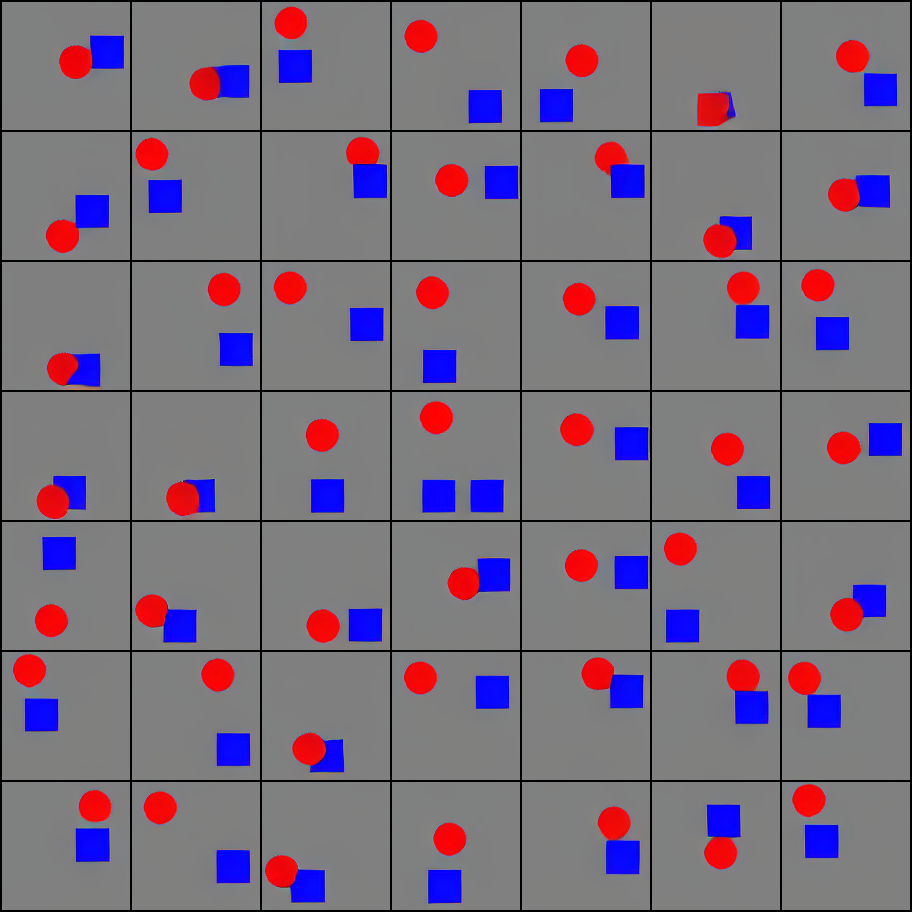

In [8]:
print("pipeline.text_encoder.dtype", pipeline.text_encoder.dtype)
print("pipeline.transformer.dtype", pipeline.transformer.dtype)
#%%
out = pipeline("a blue square below and to the right of a red circle", num_inference_steps=14, guidance_scale=4.5,
         num_images_per_prompt=49, generator=th.Generator(device="cuda").manual_seed(42), prompt_dtype=torch.float16)
pil_images_to_grid(out.images)

In [12]:

def split_image_into_grid(image, grid_size=5, cell_size=128, padding=2):
    """
    Split an image into a grid of subimages.
    
    Args:
        image: PIL Image to split
        grid_size: Size of grid (grid_size x grid_size)
        cell_size: Width/height of each cell in pixels
        padding: Padding between cells in pixels
        
    Returns:
        List of subimages as PIL Images
    """
    width, height = image.size
    cell_width = cell_size
    cell_height = cell_size
    
    # Verify image dimensions match expected grid
    assert (cell_width + padding) * grid_size + padding == width and \
        (cell_height + padding) * grid_size + padding == height
        
    subimages = []
    for row in range(grid_size):
        for col in range(grid_size):
            left = col * (cell_width + padding) + padding
            upper = row * (cell_height + padding) + padding
            right = left + cell_width
            lower = upper + cell_height
            subimages.append(image.crop((left, upper, right, lower)))
            
    return subimages

In [13]:
scene_info_collection

{'blue_triangle_is_above_red_triangle': {'color1': 'blue',
  'shape1': 'Triangle',
  'color2': 'red',
  'shape2': 'Triangle',
  'spatial_relationship': 'above'},
 'blue_circle_is_above_and_to_the_right_of_blue_square': {'color1': 'blue',
  'shape1': 'Circle',
  'color2': 'blue',
  'shape2': 'Square',
  'spatial_relationship': 'upper_right'},
 'blue_circle_is_above_blue_square': {'color1': 'blue',
  'shape1': 'Circle',
  'color2': 'blue',
  'shape2': 'Square',
  'spatial_relationship': 'above'},
 'blue_square_is_to_the_right_of_red_circle': {'color1': 'blue',
  'shape1': 'Square',
  'color2': 'red',
  'shape2': 'Circle',
  'spatial_relationship': 'right'},
 'blue_triangle_is_to_the_upper_left_of_red_square': {'color1': 'blue',
  'shape1': 'Triangle',
  'color2': 'red',
  'shape2': 'Square',
  'spatial_relationship': 'upper_left'},
 'circle_is_below_red_square': {'color1': None,
  'shape1': 'Circle',
  'color2': 'red',
  'shape2': 'Square',
  'spatial_relationship': 'below'},
 'red_circl

In [15]:
prompt_id = 1
prompt = "blue square below and to the right of a red circle"
out = pipeline(prompt, num_inference_steps=14, guidance_scale=4.5,
         num_images_per_prompt=81, generator=th.Generator(device="cuda").manual_seed(42), prompt_dtype=torch.float16)

torch.Size([162, 120, 4096])
torch.Size([162, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

In [29]:
# subimages = load_image_grid(step_num, prompt_id, sample_root=sample_root)
step_num = 160000
object_df_col = []
eval_score = []
scene_info = {'color1': 'blue',
  'shape1': 'Square',
  'color2': 'red',
  'shape2': 'Circle',
  'spatial_relationship': 'lower_right'}
for si, image_sample in tqdm(enumerate(out.images)):
    classified_objects_df = find_classify_objects(image_sample)
    classified_objects_df["sample_id"] = si
    object_df_col.append(classified_objects_df)
    eval_result = evaluate_parametric_relation(classified_objects_df, scene_info, color_margin=25, spatial_threshold=5)
    # eval_result = eval_func(classified_objects_df)  # Returns a dictionary
    eval_score.append({
        "step_num": step_num,
        "sample_id": si,
        "prompt": prompt,
        "prompt_id": prompt_id,
        "overall": eval_result["overall"],
        "shape": eval_result["shape"],
        "color": eval_result["color"],
        "spatial_relationship": eval_result["spatial_relationship"],
        "Dx": eval_result["Dx"],
        "Dy": eval_result["Dy"],
        "x1": eval_result["x1"],
        "y1": eval_result["y1"],
        "x2": eval_result["x2"],
        "y2": eval_result["y2"],
    })
eval_df = pd.DataFrame(eval_score)
object_df = pd.concat(object_df_col)

0it [00:00, ?it/s]

In [30]:
eval_df

step_num  sample_id                                             prompt  \
0     160000          0  blue square below and to the right of a red ci...   
1     160000          1  blue square below and to the right of a red ci...   
2     160000          2  blue square below and to the right of a red ci...   
3     160000          3  blue square below and to the right of a red ci...   
4     160000          4  blue square below and to the right of a red ci...   
..       ...        ...                                                ...   
76    160000         76  blue square below and to the right of a red ci...   
77    160000         77  blue square below and to the right of a red ci...   
78    160000         78  blue square below and to the right of a red ci...   
79    160000         79  blue square below and to the right of a red ci...   
80    160000         80  blue square below and to the right of a red ci...   

    prompt_id  overall  shape  color  spatial_relationship    Dx    Dy     x1  \
0           1    False   True   True                 False  32.0 -43.0  109.0   
1           1    False   True   True                 False  21.0 -32.0   90.0   
2           1    False   True   True                 False  36.0 -24.0   79.0   
3           1    False   True   True                 False  35.0 -45.0   77.0   
4           1    False   True   True                 False  66.0   0.0   89.0   
..        ...      ...    ...    ...                   ...   ...   ...    ...   
76          1     True   True   True                  True  72.0  31.0  110.0   
77          1    False   True   True                 False   0.0 -77.0   57.0   
78          1    False   True   True                 False  60.0   3.0   90.0   
79          1    False   True   True                 False  17.0 -60.0   73.0   
80          1    False   True   True                 False  30.0 -37.0   79.0   

      y1    x2     y2  
0   30.0  77.0   73.0  
1   63.0  69.0   95.0  
2   68.0  43.0   92.0  
3   46.0  42.0   91.0  
4   60.0  23.0   60.0  
..   ...   ...    ...  
76  84.0  38.0   53.0  
77  30.0  57.0  107.0  
78  62.0  30.0   59.0  
79  31.0  56.0   91.0  
80  61.0  49.0   98.0  

[81 rows x 14 columns]

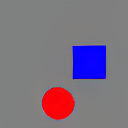

In [34]:
out.images[5]

### Mass produce 

In [37]:
from itertools import product
# you can extend these lists as needed
def generate_test_prompts_collection():
    colors = ['red', 'blue']
    target_shapes = ['square', 'triangle', 'circle']
    verticals = ['above', 'below']
    horizontals = ['to the left of', 'to the right of']
    prompts = []
    for c1, c2 in product(colors, colors):
        if c1 == c2:      # skip same‐color pairs
            continue
        for shape1, shape2 in product(target_shapes, target_shapes):
            if shape1 == shape2:
                continue
            for v in verticals:
                prompts.append(f"{c1} {shape1} is {v} the {c2} {shape2}")
            for h in horizontals:
                prompts.append(f"{c1} {shape1} is {h} the {c2} {shape2}")
            for v, h in product(verticals, horizontals):
                prompts.append(f"{c1} {shape1} is {v} and {h} the {c2} {shape2}")
    return prompts


def generate_test_prompts_collection_and_parsed_words():
    colors = ['red', 'blue']
    target_shapes = ['square', 'triangle', 'circle']
    verticals = ['above', 'below']
    horizontals = ['to the left of', 'to the right of']
    prompts = []
    parsed_words = []
    for c1, c2 in product(colors, colors):
        if c1 == c2:      # skip same‐color pairs
            continue
        for shape1, shape2 in product(target_shapes, target_shapes):
            if shape1 == shape2:
                continue
            for v in verticals:
                prompts.append(f"{c1} {shape1} is {v} the {c2} {shape2}")
                parsed_words.append({"color1": c1, "shape1": shape1, "relation": [v], "color2": c2, "shape2": shape2, "prop": ["is", "the"], "prompt": prompts[-1]})
            for h in horizontals:
                prompts.append(f"{c1} {shape1} is {h} the {c2} {shape2}")
                parsed_words.append({"color1": c1, "shape1": shape1, "relation": [h.split(" ")[2]], "color2": c2, "shape2": shape2, "prop": ["is", "the", "to", "of"], "prompt": prompts[-1]})
            for v, h in product(verticals, horizontals):
                prompts.append(f"{c1} {shape1} is {v} and {h} the {c2} {shape2}")
                parsed_words.append({"color1": c1, "shape1": shape1, "relation": [v, h.split(" ")[2]], "color2": c2, "shape2": shape2, "prop": ["is", "the", "to", "of", "and"], "prompt": prompts[-1]})
    return prompts, parsed_words


In [ ]:
prompts, parsed_words = generate_test_prompts_collection_and_parsed_words()
prompt_df = pd.DataFrame(parsed_words)
prompt_df["relation_str"] = prompt_df["relation"].apply(lambda x: "_".join(x))

In [46]:
prompt_df["relation_str"].unique()

array(['above', 'below', 'left', 'right', 'above_left', 'above_right',
       'below_left', 'below_right'], dtype=object)

In [47]:
mapping2spatial_relationship = {
    "above": "above",
    "below": "below",
    "left": "left",
    "right": "right",
    "above_left": "upper_left",
    "above_right": "upper_right",
    "below_left": "lower_left",
    "below_right": "lower_right"
}

In [63]:
savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}"
eval_dir = join(savedir, "large_scale_eval_posthoc")
os.makedirs(eval_dir, exist_ok=True)

In [67]:
step_num = 160000
eval_df_all = []
object_df_all = []
for prompt_id, row in tqdm(prompt_df.iterrows()):
    prompt = row["prompt"]
    scene_info = {
        "color1": row["color1"],
        "shape1": row["shape1"],
        "color2": row["color2"],
        "shape2": row["shape2"],
        "spatial_relationship": mapping2spatial_relationship[row["relation_str"]]
    }
    out = pipeline(prompt, num_inference_steps=14, guidance_scale=4.5,
         num_images_per_prompt=100, generator=th.Generator(device="cuda").manual_seed(42), prompt_dtype=torch.float16)
    object_df_col = []
    eval_score = []
    for si, image_sample in tqdm(enumerate(out.images)):
        classified_objects_df = find_classify_objects(image_sample)
        classified_objects_df["sample_id"] = si
        object_df_col.append(classified_objects_df)
        eval_result = evaluate_parametric_relation(classified_objects_df, scene_info, color_margin=25, spatial_threshold=5)
        # eval_result = eval_func(classified_objects_df)  # Returns a dictionary
        eval_score.append({
            "step_num": step_num,
            "sample_id": si,
            "prompt": prompt,
            "prompt_id": prompt_id,
            "overall": eval_result["overall"],
            "shape": eval_result["shape"],
            "color": eval_result["color"],
            "spatial_relationship": eval_result["spatial_relationship"],
            "Dx": eval_result["Dx"],
            "Dy": eval_result["Dy"],
            "x1": eval_result["x1"],
            "y1": eval_result["y1"],
            "x2": eval_result["x2"],
            "y2": eval_result["y2"],
        })
    eval_df = pd.DataFrame(eval_score)
    object_df = pd.concat(object_df_col)
    eval_df.to_csv(join(eval_dir, f"eval_df_{prompt_id}_{prompt.replace(' ', '_')}.csv"), index=False)
    object_df.to_pickle(join(eval_dir, f"object_df_{prompt_id}_{prompt.replace(' ', '_')}.pkl"))
    # save object_df
    acc_overall = eval_df["overall"].mean()
    acc_shape = eval_df["shape"].mean()
    acc_color = eval_df["color"].mean()
    acc_spatial_relationship = eval_df["spatial_relationship"].mean()
    Dx_mean = eval_df["Dx"].mean(skipna=True)
    Dy_mean = eval_df["Dy"].mean(skipna=True)
    Dx_std = eval_df["Dx"].std(skipna=True)
    Dy_std = eval_df["Dy"].std(skipna=True)
    N_valid = eval_df["Dx"].count()
    N_total = len(eval_df)
    print(f"prompt: {prompt} (id: {prompt_id}) {scene_info}")
    print(f"accuracy color {acc_color:.2f}, shape {acc_shape:.2f}, spatial_relationship {acc_spatial_relationship:.2f}, overall {acc_overall:.2f}")
    print(f"Dx {Dx_mean:.2f} ± {Dx_std:.2f}, Dy {Dy_mean:.2f} ± {Dy_std:.2f} (valid N={N_valid}/{N_total})")
    eval_df_all.append(eval_df)
    object_df_all.append(object_df)
    torch.cuda.empty_cache()
    
eval_df_all = pd.concat(eval_df_all)
object_df_all = pd.concat(object_df_all)
eval_df_all.to_csv(join(eval_dir, f"eval_df_all_prompts.csv"), index=False)
object_df_all.to_pickle(join(eval_dir, f"object_df_all_prompts.pkl"))

0it [00:00, ?it/s]

torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red square is above the blue triangle (id: 0) {'color1': 'red', 'shape1': 'square', 'color2': 'blue', 'shape2': 'triangle', 'spatial_relationship': 'above'}
accuracy color 0.94, shape 0.81, spatial_relationship 0.36, overall 0.36
Dx 0.43 ± 14.94, Dy -61.10 ± 16.58 (valid N=81/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red square is below the blue triangle (id: 1) {'color1': 'red', 'shape1': 'square', 'color2': 'blue', 'shape2': 'triangle', 'spatial_relationship': 'below'}
accuracy color 0.50, shape 0.49, spatial_relationship 0.27, overall 0.27
Dx -22.30 ± 34.80, Dy 40.53 ± 12.15 (valid N=47/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red square is to the left of the blue triangle (id: 2) {'color1': 'red', 'shape1': 'square', 'color2': 'blue', 'shape2': 'triangle', 'spatial_relationship': 'left'}
accuracy color 1.00, shape 0.98, spatial_relationship 0.35, overall 0.35
Dx -72.73 ± 14.22, Dy -12.59 ± 11.94 (valid N=98/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red square is to the right of the blue triangle (id: 3) {'color1': 'red', 'shape1': 'square', 'color2': 'blue', 'shape2': 'triangle', 'spatial_relationship': 'right'}
accuracy color 1.00, shape 0.92, spatial_relationship 0.00, overall 0.00
Dx -40.90 ± 25.36, Dy -36.73 ± 23.70 (valid N=92/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red square is above and to the left of the blue triangle (id: 4) {'color1': 'red', 'shape1': 'square', 'color2': 'blue', 'shape2': 'triangle', 'spatial_relationship': 'upper_left'}
accuracy color 1.00, shape 0.97, spatial_relationship 0.96, overall 0.96
Dx -53.37 ± 23.32, Dy -29.69 ± 13.67 (valid N=97/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red square is above and to the right of the blue triangle (id: 5) {'color1': 'red', 'shape1': 'square', 'color2': 'blue', 'shape2': 'triangle', 'spatial_relationship': 'upper_right'}
accuracy color 1.00, shape 0.95, spatial_relationship 0.64, overall 0.64
Dx 11.19 ± 17.18, Dy -48.27 ± 19.34 (valid N=95/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red square is below and to the left of the blue triangle (id: 6) {'color1': 'red', 'shape1': 'square', 'color2': 'blue', 'shape2': 'triangle', 'spatial_relationship': 'lower_left'}
accuracy color 1.00, shape 0.97, spatial_relationship 0.74, overall 0.74
Dx -60.14 ± 19.22, Dy 18.26 ± 19.07 (valid N=97/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red square is below and to the right of the blue triangle (id: 7) {'color1': 'red', 'shape1': 'square', 'color2': 'blue', 'shape2': 'triangle', 'spatial_relationship': 'lower_right'}
accuracy color 0.87, shape 0.68, spatial_relationship 0.06, overall 0.06
Dx -14.69 ± 31.61, Dy 7.99 ± 26.96 (valid N=67/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red square is above the blue circle (id: 8) {'color1': 'red', 'shape1': 'square', 'color2': 'blue', 'shape2': 'circle', 'spatial_relationship': 'above'}
accuracy color 0.96, shape 0.92, spatial_relationship 0.38, overall 0.38
Dx 15.41 ± 21.83, Dy -65.60 ± 14.16 (valid N=91/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red square is below the blue circle (id: 9) {'color1': 'red', 'shape1': 'square', 'color2': 'blue', 'shape2': 'circle', 'spatial_relationship': 'below'}
accuracy color 0.39, shape 0.25, spatial_relationship 0.11, overall 0.11
Dx -10.26 ± 16.62, Dy 52.78 ± 22.62 (valid N=23/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red square is to the left of the blue circle (id: 10) {'color1': 'red', 'shape1': 'square', 'color2': 'blue', 'shape2': 'circle', 'spatial_relationship': 'left'}
accuracy color 0.94, shape 0.81, spatial_relationship 0.36, overall 0.36
Dx -63.54 ± 16.81, Dy -7.96 ± 18.22 (valid N=81/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red square is to the right of the blue circle (id: 11) {'color1': 'red', 'shape1': 'square', 'color2': 'blue', 'shape2': 'circle', 'spatial_relationship': 'right'}
accuracy color 0.64, shape 0.32, spatial_relationship 0.01, overall 0.01
Dx -36.93 ± 28.13, Dy -20.73 ± 23.99 (valid N=30/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red square is above and to the left of the blue circle (id: 12) {'color1': 'red', 'shape1': 'square', 'color2': 'blue', 'shape2': 'circle', 'spatial_relationship': 'upper_left'}
accuracy color 1.00, shape 0.99, spatial_relationship 0.98, overall 0.98
Dx -42.23 ± 19.53, Dy -40.89 ± 22.16 (valid N=99/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red square is above and to the right of the blue circle (id: 13) {'color1': 'red', 'shape1': 'square', 'color2': 'blue', 'shape2': 'circle', 'spatial_relationship': 'upper_right'}
accuracy color 1.00, shape 0.95, spatial_relationship 0.53, overall 0.53
Dx 15.12 ± 30.06, Dy -63.31 ± 15.67 (valid N=94/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red square is below and to the left of the blue circle (id: 14) {'color1': 'red', 'shape1': 'square', 'color2': 'blue', 'shape2': 'circle', 'spatial_relationship': 'lower_left'}
accuracy color 1.00, shape 0.97, spatial_relationship 0.89, overall 0.89
Dx -52.62 ± 21.39, Dy 34.67 ± 22.09 (valid N=97/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red square is below and to the right of the blue circle (id: 15) {'color1': 'red', 'shape1': 'square', 'color2': 'blue', 'shape2': 'circle', 'spatial_relationship': 'lower_right'}
accuracy color 0.98, shape 0.86, spatial_relationship 0.00, overall 0.00
Dx -22.55 ± 18.92, Dy 40.53 ± 21.30 (valid N=86/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red triangle is above the blue square (id: 16) {'color1': 'red', 'shape1': 'triangle', 'color2': 'blue', 'shape2': 'square', 'spatial_relationship': 'above'}
accuracy color 0.93, shape 0.94, spatial_relationship 0.41, overall 0.41
Dx -2.98 ± 8.24, Dy -60.76 ± 12.82 (valid N=91/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red triangle is below the blue square (id: 17) {'color1': 'red', 'shape1': 'triangle', 'color2': 'blue', 'shape2': 'square', 'spatial_relationship': 'below'}
accuracy color 0.38, shape 0.31, spatial_relationship 0.15, overall 0.15
Dx -6.12 ± 18.93, Dy 43.88 ± 18.22 (valid N=26/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red triangle is to the left of the blue square (id: 18) {'color1': 'red', 'shape1': 'triangle', 'color2': 'blue', 'shape2': 'square', 'spatial_relationship': 'left'}
accuracy color 0.95, shape 0.90, spatial_relationship 0.28, overall 0.28
Dx -51.76 ± 21.31, Dy -24.18 ± 28.07 (valid N=87/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red triangle is to the right of the blue square (id: 19) {'color1': 'red', 'shape1': 'triangle', 'color2': 'blue', 'shape2': 'square', 'spatial_relationship': 'right'}
accuracy color 0.91, shape 0.88, spatial_relationship 0.00, overall 0.00
Dx -31.14 ± 17.49, Dy -45.17 ± 29.41 (valid N=83/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red triangle is above and to the left of the blue square (id: 20) {'color1': 'red', 'shape1': 'triangle', 'color2': 'blue', 'shape2': 'square', 'spatial_relationship': 'upper_left'}
accuracy color 0.98, shape 0.92, spatial_relationship 0.92, overall 0.92
Dx -33.76 ± 16.25, Dy -56.26 ± 22.17 (valid N=92/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red triangle is above and to the right of the blue square (id: 21) {'color1': 'red', 'shape1': 'triangle', 'color2': 'blue', 'shape2': 'square', 'spatial_relationship': 'upper_right'}
accuracy color 0.97, shape 0.98, spatial_relationship 0.37, overall 0.37
Dx 0.67 ± 20.96, Dy -61.00 ± 16.00 (valid N=95/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red triangle is below and to the left of the blue square (id: 22) {'color1': 'red', 'shape1': 'triangle', 'color2': 'blue', 'shape2': 'square', 'spatial_relationship': 'lower_left'}
accuracy color 0.98, shape 0.92, spatial_relationship 0.42, overall 0.42
Dx -46.15 ± 18.70, Dy -3.73 ± 29.02 (valid N=91/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red triangle is below and to the right of the blue square (id: 23) {'color1': 'red', 'shape1': 'triangle', 'color2': 'blue', 'shape2': 'square', 'spatial_relationship': 'lower_right'}
accuracy color 0.89, shape 0.88, spatial_relationship 0.00, overall 0.00
Dx -24.08 ± 17.88, Dy -41.90 ± 31.20 (valid N=86/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red triangle is above the blue circle (id: 24) {'color1': 'red', 'shape1': 'triangle', 'color2': 'blue', 'shape2': 'circle', 'spatial_relationship': 'above'}
accuracy color 0.83, shape 0.81, spatial_relationship 0.36, overall 0.36
Dx 6.15 ± 14.42, Dy -55.08 ± 10.78 (valid N=80/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red triangle is below the blue circle (id: 25) {'color1': 'red', 'shape1': 'triangle', 'color2': 'blue', 'shape2': 'circle', 'spatial_relationship': 'below'}
accuracy color 0.71, shape 0.49, spatial_relationship 0.17, overall 0.17
Dx -10.11 ± 11.11, Dy 56.98 ± 17.07 (valid N=44/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red triangle is to the left of the blue circle (id: 26) {'color1': 'red', 'shape1': 'triangle', 'color2': 'blue', 'shape2': 'circle', 'spatial_relationship': 'left'}
accuracy color 0.87, shape 0.84, spatial_relationship 0.23, overall 0.23
Dx -45.82 ± 18.71, Dy -17.39 ± 23.13 (valid N=83/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red triangle is to the right of the blue circle (id: 27) {'color1': 'red', 'shape1': 'triangle', 'color2': 'blue', 'shape2': 'circle', 'spatial_relationship': 'right'}
accuracy color 0.91, shape 0.86, spatial_relationship 0.00, overall 0.00
Dx -35.59 ± 15.19, Dy -33.82 ± 24.83 (valid N=85/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red triangle is above and to the left of the blue circle (id: 28) {'color1': 'red', 'shape1': 'triangle', 'color2': 'blue', 'shape2': 'circle', 'spatial_relationship': 'upper_left'}
accuracy color 1.00, shape 0.97, spatial_relationship 0.97, overall 0.97
Dx -41.01 ± 16.33, Dy -37.57 ± 17.36 (valid N=97/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red triangle is above and to the right of the blue circle (id: 29) {'color1': 'red', 'shape1': 'triangle', 'color2': 'blue', 'shape2': 'circle', 'spatial_relationship': 'upper_right'}
accuracy color 0.99, shape 0.99, spatial_relationship 0.09, overall 0.09
Dx -15.65 ± 21.13, Dy -51.81 ± 16.80 (valid N=99/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red triangle is below and to the left of the blue circle (id: 30) {'color1': 'red', 'shape1': 'triangle', 'color2': 'blue', 'shape2': 'circle', 'spatial_relationship': 'lower_left'}
accuracy color 0.99, shape 1.00, spatial_relationship 0.74, overall 0.74
Dx -52.31 ± 15.88, Dy 17.29 ± 26.17 (valid N=99/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red triangle is below and to the right of the blue circle (id: 31) {'color1': 'red', 'shape1': 'triangle', 'color2': 'blue', 'shape2': 'circle', 'spatial_relationship': 'lower_right'}
accuracy color 0.97, shape 0.97, spatial_relationship 0.00, overall 0.00
Dx -42.77 ± 14.79, Dy -19.37 ± 29.22 (valid N=94/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red circle is above the blue square (id: 32) {'color1': 'red', 'shape1': 'circle', 'color2': 'blue', 'shape2': 'square', 'spatial_relationship': 'above'}
accuracy color 0.97, shape 0.99, spatial_relationship 0.44, overall 0.44
Dx 9.50 ± 13.96, Dy -58.15 ± 16.92 (valid N=96/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red circle is below the blue square (id: 33) {'color1': 'red', 'shape1': 'circle', 'color2': 'blue', 'shape2': 'square', 'spatial_relationship': 'below'}
accuracy color 0.06, shape 0.20, spatial_relationship 0.00, overall 0.00
Dx -63.25 ± 6.65, Dy 9.75 ± 6.75 (valid N=4/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red circle is to the left of the blue square (id: 34) {'color1': 'red', 'shape1': 'circle', 'color2': 'blue', 'shape2': 'square', 'spatial_relationship': 'left'}
accuracy color 0.98, shape 0.99, spatial_relationship 0.08, overall 0.08
Dx -69.37 ± 17.96, Dy -25.44 ± 22.54 (valid N=97/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red circle is to the right of the blue square (id: 35) {'color1': 'red', 'shape1': 'circle', 'color2': 'blue', 'shape2': 'square', 'spatial_relationship': 'right'}
accuracy color 0.94, shape 1.00, spatial_relationship 0.00, overall 0.00
Dx -42.71 ± 22.72, Dy -35.06 ± 25.79 (valid N=94/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red circle is above and to the left of the blue square (id: 36) {'color1': 'red', 'shape1': 'circle', 'color2': 'blue', 'shape2': 'square', 'spatial_relationship': 'upper_left'}
accuracy color 0.99, shape 1.00, spatial_relationship 0.93, overall 0.93
Dx -34.37 ± 17.84, Dy -57.33 ± 19.79 (valid N=99/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red circle is above and to the right of the blue square (id: 37) {'color1': 'red', 'shape1': 'circle', 'color2': 'blue', 'shape2': 'square', 'spatial_relationship': 'upper_right'}
accuracy color 1.00, shape 0.98, spatial_relationship 0.48, overall 0.48
Dx 11.53 ± 22.00, Dy -60.94 ± 19.74 (valid N=98/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red circle is below and to the left of the blue square (id: 38) {'color1': 'red', 'shape1': 'circle', 'color2': 'blue', 'shape2': 'square', 'spatial_relationship': 'lower_left'}
accuracy color 0.98, shape 0.99, spatial_relationship 0.18, overall 0.18
Dx -61.36 ± 16.25, Dy -13.90 ± 21.83 (valid N=97/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red circle is below and to the right of the blue square (id: 39) {'color1': 'red', 'shape1': 'circle', 'color2': 'blue', 'shape2': 'square', 'spatial_relationship': 'lower_right'}
accuracy color 0.79, shape 0.98, spatial_relationship 0.01, overall 0.01
Dx -21.71 ± 25.02, Dy -33.10 ± 21.20 (valid N=78/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red circle is above the blue triangle (id: 40) {'color1': 'red', 'shape1': 'circle', 'color2': 'blue', 'shape2': 'triangle', 'spatial_relationship': 'above'}
accuracy color 1.00, shape 0.98, spatial_relationship 0.33, overall 0.33
Dx 8.59 ± 12.71, Dy -58.08 ± 19.27 (valid N=98/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red circle is below the blue triangle (id: 41) {'color1': 'red', 'shape1': 'circle', 'color2': 'blue', 'shape2': 'triangle', 'spatial_relationship': 'below'}
accuracy color 0.18, shape 0.85, spatial_relationship 0.06, overall 0.06
Dx -3.35 ± 11.54, Dy 26.12 ± 15.56 (valid N=17/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red circle is to the left of the blue triangle (id: 42) {'color1': 'red', 'shape1': 'circle', 'color2': 'blue', 'shape2': 'triangle', 'spatial_relationship': 'left'}
accuracy color 0.99, shape 1.00, spatial_relationship 0.11, overall 0.11
Dx -67.28 ± 16.59, Dy -18.70 ± 17.05 (valid N=99/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red circle is to the right of the blue triangle (id: 43) {'color1': 'red', 'shape1': 'circle', 'color2': 'blue', 'shape2': 'triangle', 'spatial_relationship': 'right'}
accuracy color 1.00, shape 1.00, spatial_relationship 0.00, overall 0.00
Dx -54.13 ± 17.47, Dy -31.09 ± 22.52 (valid N=100/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red circle is above and to the left of the blue triangle (id: 44) {'color1': 'red', 'shape1': 'circle', 'color2': 'blue', 'shape2': 'triangle', 'spatial_relationship': 'upper_left'}
accuracy color 0.99, shape 1.00, spatial_relationship 0.98, overall 0.98
Dx -36.21 ± 21.46, Dy -35.36 ± 12.13 (valid N=99/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red circle is above and to the right of the blue triangle (id: 45) {'color1': 'red', 'shape1': 'circle', 'color2': 'blue', 'shape2': 'triangle', 'spatial_relationship': 'upper_right'}
accuracy color 1.00, shape 1.00, spatial_relationship 0.42, overall 0.42
Dx 4.25 ± 17.52, Dy -50.19 ± 19.08 (valid N=100/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red circle is below and to the left of the blue triangle (id: 46) {'color1': 'red', 'shape1': 'circle', 'color2': 'blue', 'shape2': 'triangle', 'spatial_relationship': 'lower_left'}
accuracy color 0.97, shape 0.99, spatial_relationship 0.30, overall 0.30
Dx -63.26 ± 15.78, Dy -1.94 ± 12.47 (valid N=97/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: red circle is below and to the right of the blue triangle (id: 47) {'color1': 'red', 'shape1': 'circle', 'color2': 'blue', 'shape2': 'triangle', 'spatial_relationship': 'lower_right'}
accuracy color 0.92, shape 0.97, spatial_relationship 0.00, overall 0.00
Dx -24.80 ± 22.45, Dy -24.73 ± 18.17 (valid N=92/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue square is above the red triangle (id: 48) {'color1': 'blue', 'shape1': 'square', 'color2': 'red', 'shape2': 'triangle', 'spatial_relationship': 'above'}
accuracy color 0.98, shape 0.90, spatial_relationship 0.49, overall 0.49
Dx -7.81 ± 15.26, Dy -52.02 ± 18.28 (valid N=90/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue square is below the red triangle (id: 49) {'color1': 'blue', 'shape1': 'square', 'color2': 'red', 'shape2': 'triangle', 'spatial_relationship': 'below'}
accuracy color 0.77, shape 0.81, spatial_relationship 0.02, overall 0.02
Dx -47.78 ± 19.45, Dy -1.09 ± 20.17 (valid N=77/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue square is to the left of the red triangle (id: 50) {'color1': 'blue', 'shape1': 'square', 'color2': 'red', 'shape2': 'triangle', 'spatial_relationship': 'left'}
accuracy color 0.97, shape 0.99, spatial_relationship 0.04, overall 0.04
Dx -47.91 ± 17.40, Dy -17.64 ± 9.96 (valid N=96/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue square is to the right of the red triangle (id: 51) {'color1': 'blue', 'shape1': 'square', 'color2': 'red', 'shape2': 'triangle', 'spatial_relationship': 'right'}
accuracy color 0.98, shape 1.00, spatial_relationship 0.00, overall 0.00
Dx -46.82 ± 15.54, Dy -24.62 ± 18.56 (valid N=98/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue square is above and to the left of the red triangle (id: 52) {'color1': 'blue', 'shape1': 'square', 'color2': 'red', 'shape2': 'triangle', 'spatial_relationship': 'upper_left'}
accuracy color 0.99, shape 0.98, spatial_relationship 0.98, overall 0.98
Dx -42.69 ± 14.95, Dy -55.30 ± 23.75 (valid N=98/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue square is above and to the right of the red triangle (id: 53) {'color1': 'blue', 'shape1': 'square', 'color2': 'red', 'shape2': 'triangle', 'spatial_relationship': 'upper_right'}
accuracy color 1.00, shape 0.98, spatial_relationship 0.17, overall 0.17
Dx -14.09 ± 22.44, Dy -56.33 ± 22.30 (valid N=98/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue square is below and to the left of the red triangle (id: 54) {'color1': 'blue', 'shape1': 'square', 'color2': 'red', 'shape2': 'triangle', 'spatial_relationship': 'lower_left'}
accuracy color 0.94, shape 0.97, spatial_relationship 0.06, overall 0.06
Dx -56.53 ± 15.48, Dy -16.70 ± 17.31 (valid N=91/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue square is below and to the right of the red triangle (id: 55) {'color1': 'blue', 'shape1': 'square', 'color2': 'red', 'shape2': 'triangle', 'spatial_relationship': 'lower_right'}
accuracy color 0.90, shape 0.99, spatial_relationship 0.00, overall 0.00
Dx -48.41 ± 16.64, Dy -32.20 ± 21.93 (valid N=90/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue square is above the red circle (id: 56) {'color1': 'blue', 'shape1': 'square', 'color2': 'red', 'shape2': 'circle', 'spatial_relationship': 'above'}
accuracy color 0.97, shape 0.96, spatial_relationship 0.56, overall 0.56
Dx -5.79 ± 9.26, Dy -54.15 ± 12.20 (valid N=96/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue square is below the red circle (id: 57) {'color1': 'blue', 'shape1': 'square', 'color2': 'red', 'shape2': 'circle', 'spatial_relationship': 'below'}
accuracy color 0.98, shape 0.95, spatial_relationship 0.01, overall 0.01
Dx -45.46 ± 16.68, Dy 15.47 ± 15.11 (valid N=95/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue square is to the left of the red circle (id: 58) {'color1': 'blue', 'shape1': 'square', 'color2': 'red', 'shape2': 'circle', 'spatial_relationship': 'left'}
accuracy color 1.00, shape 0.97, spatial_relationship 0.07, overall 0.07
Dx -49.94 ± 17.54, Dy -25.70 ± 18.09 (valid N=97/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue square is to the right of the red circle (id: 59) {'color1': 'blue', 'shape1': 'square', 'color2': 'red', 'shape2': 'circle', 'spatial_relationship': 'right'}
accuracy color 1.00, shape 1.00, spatial_relationship 0.00, overall 0.00
Dx -51.39 ± 16.33, Dy -26.26 ± 18.99 (valid N=100/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue square is above and to the left of the red circle (id: 60) {'color1': 'blue', 'shape1': 'square', 'color2': 'red', 'shape2': 'circle', 'spatial_relationship': 'upper_left'}
accuracy color 1.00, shape 0.98, spatial_relationship 0.98, overall 0.98
Dx -46.96 ± 18.86, Dy -50.10 ± 21.64 (valid N=98/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue square is above and to the right of the red circle (id: 61) {'color1': 'blue', 'shape1': 'square', 'color2': 'red', 'shape2': 'circle', 'spatial_relationship': 'upper_right'}
accuracy color 1.00, shape 0.98, spatial_relationship 0.00, overall 0.00
Dx -30.97 ± 20.57, Dy -57.52 ± 18.08 (valid N=98/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue square is below and to the left of the red circle (id: 62) {'color1': 'blue', 'shape1': 'square', 'color2': 'red', 'shape2': 'circle', 'spatial_relationship': 'lower_left'}
accuracy color 1.00, shape 0.99, spatial_relationship 0.87, overall 0.87
Dx -65.10 ± 13.86, Dy 27.82 ± 27.40 (valid N=98/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue square is below and to the right of the red circle (id: 63) {'color1': 'blue', 'shape1': 'square', 'color2': 'red', 'shape2': 'circle', 'spatial_relationship': 'lower_right'}
accuracy color 0.99, shape 0.98, spatial_relationship 0.00, overall 0.00
Dx -60.26 ± 15.26, Dy 18.50 ± 27.55 (valid N=98/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue triangle is above the red square (id: 64) {'color1': 'blue', 'shape1': 'triangle', 'color2': 'red', 'shape2': 'square', 'spatial_relationship': 'above'}
accuracy color 0.86, shape 0.83, spatial_relationship 0.29, overall 0.29
Dx -1.28 ± 16.92, Dy -43.78 ± 17.56 (valid N=79/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue triangle is below the red square (id: 65) {'color1': 'blue', 'shape1': 'triangle', 'color2': 'red', 'shape2': 'square', 'spatial_relationship': 'below'}
accuracy color 0.47, shape 0.54, spatial_relationship 0.00, overall 0.00
Dx -43.27 ± 17.88, Dy 11.27 ± 12.27 (valid N=44/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue triangle is to the left of the red square (id: 66) {'color1': 'blue', 'shape1': 'triangle', 'color2': 'red', 'shape2': 'square', 'spatial_relationship': 'left'}
accuracy color 0.69, shape 0.73, spatial_relationship 0.04, overall 0.04
Dx -38.64 ± 13.30, Dy -31.93 ± 20.58 (valid N=59/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue triangle is to the right of the red square (id: 67) {'color1': 'blue', 'shape1': 'triangle', 'color2': 'red', 'shape2': 'square', 'spatial_relationship': 'right'}
accuracy color 0.74, shape 0.74, spatial_relationship 0.00, overall 0.00
Dx -40.86 ± 13.57, Dy -29.42 ± 21.33 (valid N=65/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue triangle is above and to the left of the red square (id: 68) {'color1': 'blue', 'shape1': 'triangle', 'color2': 'red', 'shape2': 'square', 'spatial_relationship': 'upper_left'}
accuracy color 0.96, shape 0.94, spatial_relationship 0.92, overall 0.92
Dx -39.67 ± 14.31, Dy -45.03 ± 16.55 (valid N=92/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue triangle is above and to the right of the red square (id: 69) {'color1': 'blue', 'shape1': 'triangle', 'color2': 'red', 'shape2': 'square', 'spatial_relationship': 'upper_right'}
accuracy color 0.98, shape 0.98, spatial_relationship 0.02, overall 0.02
Dx -32.08 ± 17.70, Dy -53.36 ± 16.75 (valid N=98/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue triangle is below and to the left of the red square (id: 70) {'color1': 'blue', 'shape1': 'triangle', 'color2': 'red', 'shape2': 'square', 'spatial_relationship': 'lower_left'}
accuracy color 0.92, shape 0.88, spatial_relationship 0.16, overall 0.16
Dx -50.62 ± 17.36, Dy -11.91 ± 24.86 (valid N=85/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue triangle is below and to the right of the red square (id: 71) {'color1': 'blue', 'shape1': 'triangle', 'color2': 'red', 'shape2': 'square', 'spatial_relationship': 'lower_right'}
accuracy color 0.84, shape 0.86, spatial_relationship 0.00, overall 0.00
Dx -52.74 ± 16.40, Dy -15.20 ± 25.66 (valid N=81/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue triangle is above the red circle (id: 72) {'color1': 'blue', 'shape1': 'triangle', 'color2': 'red', 'shape2': 'circle', 'spatial_relationship': 'above'}
accuracy color 0.74, shape 0.74, spatial_relationship 0.45, overall 0.45
Dx 1.68 ± 12.73, Dy -51.31 ± 12.94 (valid N=74/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue triangle is below the red circle (id: 73) {'color1': 'blue', 'shape1': 'triangle', 'color2': 'red', 'shape2': 'circle', 'spatial_relationship': 'below'}
accuracy color 0.73, shape 0.67, spatial_relationship 0.02, overall 0.02
Dx -36.29 ± 20.45, Dy 22.78 ± 22.18 (valid N=63/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue triangle is to the left of the red circle (id: 74) {'color1': 'blue', 'shape1': 'triangle', 'color2': 'red', 'shape2': 'circle', 'spatial_relationship': 'left'}
accuracy color 0.90, shape 0.90, spatial_relationship 0.04, overall 0.04
Dx -45.82 ± 17.26, Dy -30.08 ± 17.32 (valid N=85/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue triangle is to the right of the red circle (id: 75) {'color1': 'blue', 'shape1': 'triangle', 'color2': 'red', 'shape2': 'circle', 'spatial_relationship': 'right'}
accuracy color 0.86, shape 0.91, spatial_relationship 0.00, overall 0.00
Dx -46.74 ± 17.24, Dy -27.16 ± 16.84 (valid N=86/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue triangle is above and to the left of the red circle (id: 76) {'color1': 'blue', 'shape1': 'triangle', 'color2': 'red', 'shape2': 'circle', 'spatial_relationship': 'upper_left'}
accuracy color 0.96, shape 0.96, spatial_relationship 0.94, overall 0.94
Dx -49.44 ± 21.18, Dy -43.00 ± 18.96 (valid N=94/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue triangle is above and to the right of the red circle (id: 77) {'color1': 'blue', 'shape1': 'triangle', 'color2': 'red', 'shape2': 'circle', 'spatial_relationship': 'upper_right'}
accuracy color 0.96, shape 0.99, spatial_relationship 0.00, overall 0.00
Dx -33.52 ± 23.41, Dy -52.33 ± 19.24 (valid N=95/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue triangle is below and to the left of the red circle (id: 78) {'color1': 'blue', 'shape1': 'triangle', 'color2': 'red', 'shape2': 'circle', 'spatial_relationship': 'lower_left'}
accuracy color 0.97, shape 0.96, spatial_relationship 0.51, overall 0.51
Dx -61.52 ± 18.00, Dy 5.44 ± 22.18 (valid N=96/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue triangle is below and to the right of the red circle (id: 79) {'color1': 'blue', 'shape1': 'triangle', 'color2': 'red', 'shape2': 'circle', 'spatial_relationship': 'lower_right'}
accuracy color 0.92, shape 0.94, spatial_relationship 0.00, overall 0.00
Dx -57.45 ± 17.86, Dy -5.30 ± 24.04 (valid N=91/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue circle is above the red square (id: 80) {'color1': 'blue', 'shape1': 'circle', 'color2': 'red', 'shape2': 'square', 'spatial_relationship': 'above'}
accuracy color 1.00, shape 1.00, spatial_relationship 0.69, overall 0.69
Dx 5.41 ± 20.92, Dy -44.31 ± 17.27 (valid N=98/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue circle is below the red square (id: 81) {'color1': 'blue', 'shape1': 'circle', 'color2': 'red', 'shape2': 'square', 'spatial_relationship': 'below'}
accuracy color 0.73, shape 0.77, spatial_relationship 0.00, overall 0.00
Dx -41.89 ± 13.98, Dy -0.99 ± 17.69 (valid N=73/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue circle is to the left of the red square (id: 82) {'color1': 'blue', 'shape1': 'circle', 'color2': 'red', 'shape2': 'square', 'spatial_relationship': 'left'}
accuracy color 1.00, shape 1.00, spatial_relationship 0.03, overall 0.03
Dx -43.46 ± 13.29, Dy -38.75 ± 23.01 (valid N=99/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue circle is to the right of the red square (id: 83) {'color1': 'blue', 'shape1': 'circle', 'color2': 'red', 'shape2': 'square', 'spatial_relationship': 'right'}
accuracy color 1.00, shape 1.00, spatial_relationship 0.00, overall 0.00
Dx -38.02 ± 14.74, Dy -36.59 ± 23.60 (valid N=99/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue circle is above and to the left of the red square (id: 84) {'color1': 'blue', 'shape1': 'circle', 'color2': 'red', 'shape2': 'square', 'spatial_relationship': 'upper_left'}
accuracy color 1.00, shape 1.00, spatial_relationship 0.98, overall 0.98
Dx -45.68 ± 15.75, Dy -66.70 ± 18.42 (valid N=100/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue circle is above and to the right of the red square (id: 85) {'color1': 'blue', 'shape1': 'circle', 'color2': 'red', 'shape2': 'square', 'spatial_relationship': 'upper_right'}
accuracy color 1.00, shape 0.99, spatial_relationship 0.04, overall 0.04
Dx -30.42 ± 22.17, Dy -69.22 ± 18.16 (valid N=99/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue circle is below and to the left of the red square (id: 86) {'color1': 'blue', 'shape1': 'circle', 'color2': 'red', 'shape2': 'square', 'spatial_relationship': 'lower_left'}
accuracy color 1.00, shape 1.00, spatial_relationship 0.01, overall 0.01
Dx -52.75 ± 15.13, Dy -29.57 ± 19.48 (valid N=100/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue circle is below and to the right of the red square (id: 87) {'color1': 'blue', 'shape1': 'circle', 'color2': 'red', 'shape2': 'square', 'spatial_relationship': 'lower_right'}
accuracy color 1.00, shape 1.00, spatial_relationship 0.00, overall 0.00
Dx -49.72 ± 17.25, Dy -30.98 ± 19.82 (valid N=100/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue circle is above the red triangle (id: 88) {'color1': 'blue', 'shape1': 'circle', 'color2': 'red', 'shape2': 'triangle', 'spatial_relationship': 'above'}
accuracy color 0.98, shape 0.95, spatial_relationship 0.59, overall 0.59
Dx -4.32 ± 9.33, Dy -40.31 ± 13.47 (valid N=94/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue circle is below the red triangle (id: 89) {'color1': 'blue', 'shape1': 'circle', 'color2': 'red', 'shape2': 'triangle', 'spatial_relationship': 'below'}
accuracy color 0.54, shape 0.85, spatial_relationship 0.00, overall 0.00
Dx -35.96 ± 20.51, Dy -7.43 ± 16.71 (valid N=49/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue circle is to the left of the red triangle (id: 90) {'color1': 'blue', 'shape1': 'circle', 'color2': 'red', 'shape2': 'triangle', 'spatial_relationship': 'left'}
accuracy color 0.97, shape 1.00, spatial_relationship 0.04, overall 0.04
Dx -48.89 ± 20.33, Dy -27.89 ± 21.28 (valid N=97/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue circle is to the right of the red triangle (id: 91) {'color1': 'blue', 'shape1': 'circle', 'color2': 'red', 'shape2': 'triangle', 'spatial_relationship': 'right'}
accuracy color 0.99, shape 1.00, spatial_relationship 0.00, overall 0.00
Dx -47.31 ± 18.54, Dy -26.56 ± 21.10 (valid N=99/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue circle is above and to the left of the red triangle (id: 92) {'color1': 'blue', 'shape1': 'circle', 'color2': 'red', 'shape2': 'triangle', 'spatial_relationship': 'upper_left'}
accuracy color 1.00, shape 1.00, spatial_relationship 1.00, overall 1.00
Dx -44.11 ± 18.60, Dy -52.03 ± 22.67 (valid N=100/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue circle is above and to the right of the red triangle (id: 93) {'color1': 'blue', 'shape1': 'circle', 'color2': 'red', 'shape2': 'triangle', 'spatial_relationship': 'upper_right'}
accuracy color 1.00, shape 0.99, spatial_relationship 0.08, overall 0.08
Dx -15.56 ± 20.23, Dy -56.44 ± 25.39 (valid N=99/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue circle is below and to the left of the red triangle (id: 94) {'color1': 'blue', 'shape1': 'circle', 'color2': 'red', 'shape2': 'triangle', 'spatial_relationship': 'lower_left'}
accuracy color 1.00, shape 1.00, spatial_relationship 0.02, overall 0.02
Dx -59.18 ± 15.73, Dy -20.51 ± 17.82 (valid N=100/100)
torch.Size([200, 120, 4096])
torch.Size([200, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

prompt: blue circle is below and to the right of the red triangle (id: 95) {'color1': 'blue', 'shape1': 'circle', 'color2': 'red', 'shape2': 'triangle', 'spatial_relationship': 'lower_right'}
accuracy color 1.00, shape 0.99, spatial_relationship 0.00, overall 0.00
Dx -54.75 ± 16.81, Dy -27.40 ± 20.59 (valid N=99/100)


### Synopsis 

In [87]:
eval_syn_df = eval_df_all.groupby("prompt_id").mean(numeric_only=True)
eval_syn_df = eval_syn_df.rename(columns={'overall': 'overall_acc', 'shape': 'shape_acc', 'color': 'color_acc', 'spatial_relationship': 'spatial_relationship_acc'})

In [111]:
prompt_eval_syn_df = prompt_df.merge(eval_syn_df, left_index=True, right_index=True)
prompt_eval_syn_df.to_pickle(join(eval_dir, f"prompt_eval_syn_df.pkl"))

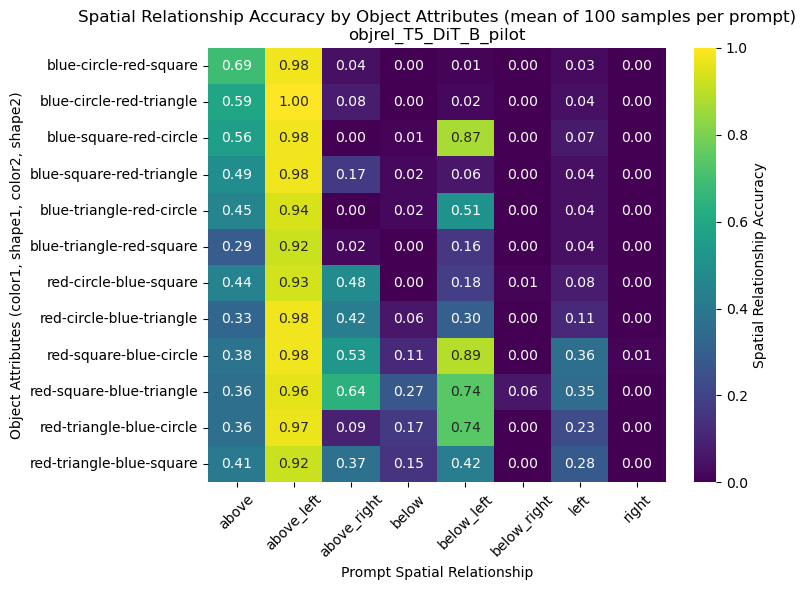

In [ ]:
# Create heatmap
import matplotlib.pyplot as plt
import seaborn as sns
# Pivot the data to create a heatmap with spatial relationships as columns
pivot_df = prompt_eval_syn_df.pivot_table(
    index=['color1', 'shape1', 'color2', 'shape2'], 
    columns='relation_str', 
    values='spatial_relationship_acc',
    aggfunc='mean'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.2f', cbar_kws={'label': 'Spatial Relationship Accuracy'})
plt.title(f'Spatial Relationship Accuracy by Object Attributes (mean of 100 samples per prompt)\n{model_run_name}')
plt.xlabel('Prompt Spatial Relationship')
plt.ylabel('Object Attributes (color1, shape1, color2, shape2)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
saveallforms(eval_dir, f"relation_eval_heatmap_spatial_relationship_acc_{model_run_name}")
plt.show()


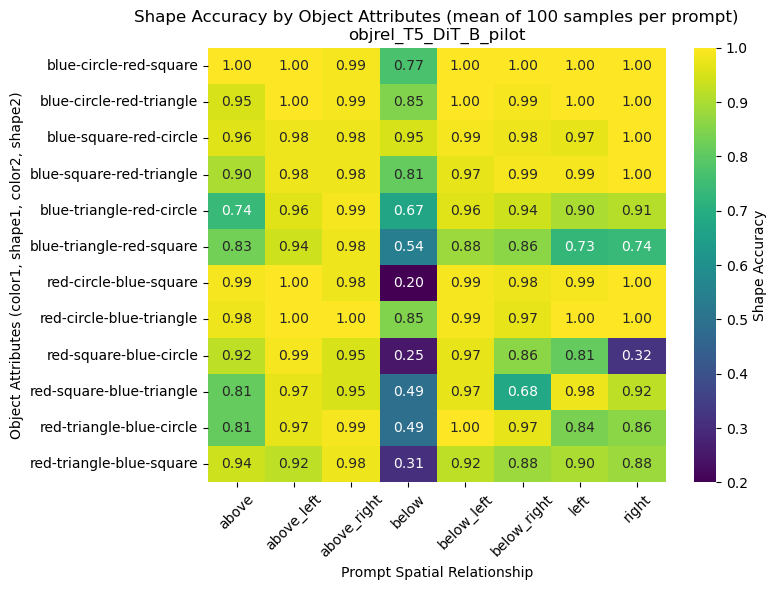

In [107]:
# Pivot the data to create a heatmap with spatial relationships as columns
pivot_df = prompt_eval_syn_df.pivot_table(
    index=['color1', 'shape1', 'color2', 'shape2'], 
    columns='relation_str', 
    values='shape_acc',
    aggfunc='mean'
)
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.2f', cbar_kws={'label': 'Shape Accuracy'})
plt.title(f'Shape Accuracy by Object Attributes (mean of 100 samples per prompt)\n{model_run_name}')
plt.xlabel('Prompt Spatial Relationship')
plt.ylabel('Object Attributes (color1, shape1, color2, shape2)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
saveallforms(eval_dir, f"relation_eval_heatmap_shape_acc_{model_run_name}")
plt.show()

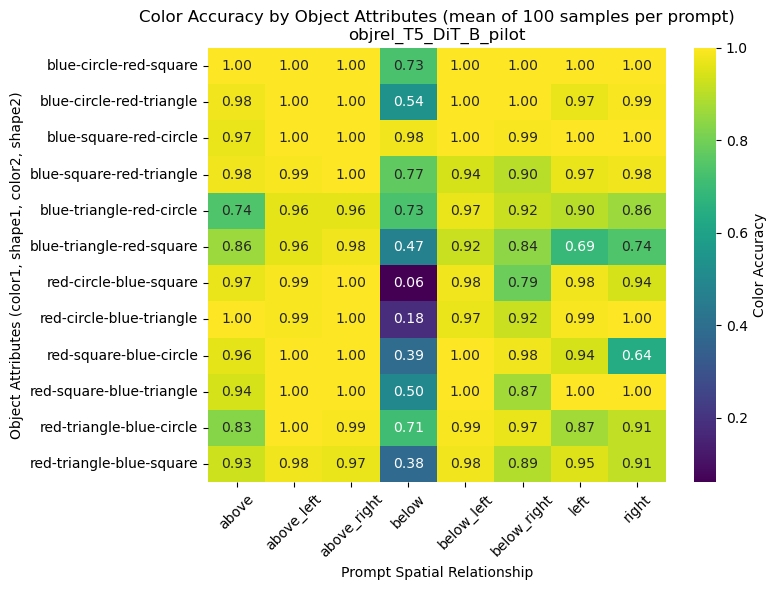

In [108]:

# Pivot the data to create a heatmap with spatial relationships as columns
pivot_df = prompt_eval_syn_df.pivot_table(
    index=['color1', 'shape1', 'color2', 'shape2'], 
    columns='relation_str', 
    values='color_acc',
    aggfunc='mean'
)
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.2f', cbar_kws={'label': 'Color Accuracy'})
plt.title(f'Color Accuracy by Object Attributes (mean of 100 samples per prompt)\n{model_run_name}')
plt.xlabel('Prompt Spatial Relationship')
plt.ylabel('Object Attributes (color1, shape1, color2, shape2)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
saveallforms(eval_dir, f"relation_eval_heatmap_color_acc_{model_run_name}")
plt.show()

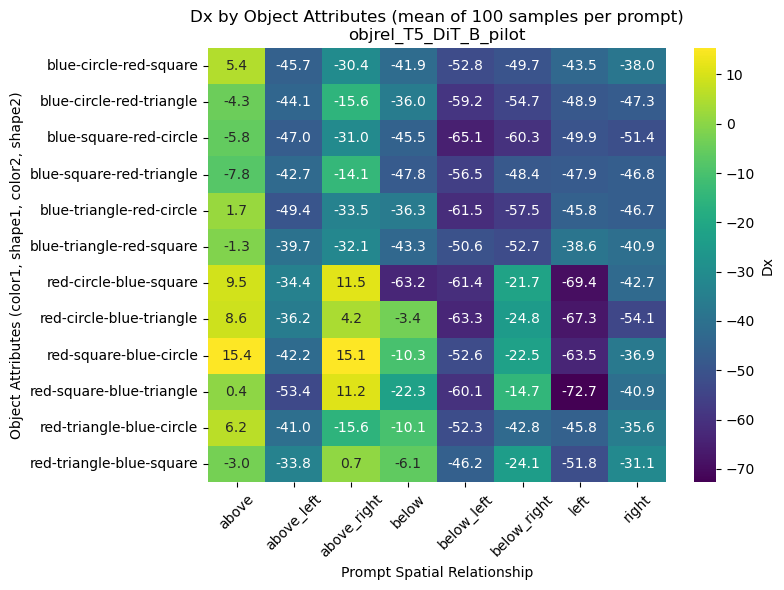

In [109]:

# Pivot the data to create a heatmap with spatial relationships as columns
pivot_df = prompt_eval_syn_df.pivot_table(
    index=['color1', 'shape1', 'color2', 'shape2'], 
    columns='relation_str', 
    values='Dx',
    aggfunc='mean'
)
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.1f', cbar_kws={'label': 'Dx'})
plt.title(f'Dx by Object Attributes (mean of 100 samples per prompt)\n{model_run_name}')
plt.xlabel('Prompt Spatial Relationship')
plt.ylabel('Object Attributes (color1, shape1, color2, shape2)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
saveallforms(eval_dir, f"relation_eval_heatmap_Dx_{model_run_name}")
plt.show()

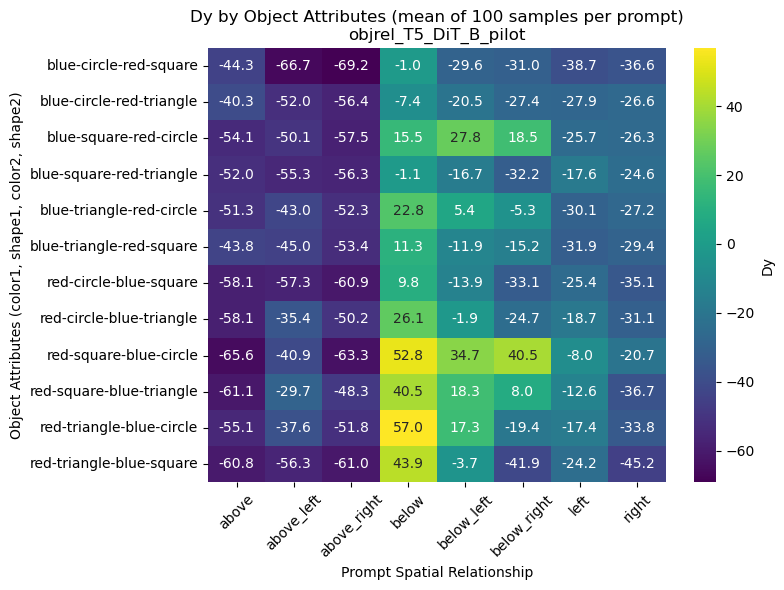

In [110]:

# Pivot the data to create a heatmap with spatial relationships as columns
pivot_df = prompt_eval_syn_df.pivot_table(
    index=['color1', 'shape1', 'color2', 'shape2'], 
    columns='relation_str', 
    values='Dy',
    aggfunc='mean'
)
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.1f', cbar_kws={'label': 'Dy'})
plt.title(f'Dy by Object Attributes (mean of 100 samples per prompt)\n{model_run_name}')
plt.xlabel('Prompt Spatial Relationship')
plt.ylabel('Object Attributes (color1, shape1, color2, shape2)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
saveallforms(eval_dir, f"relation_eval_heatmap_Dy_{model_run_name}")
plt.show()

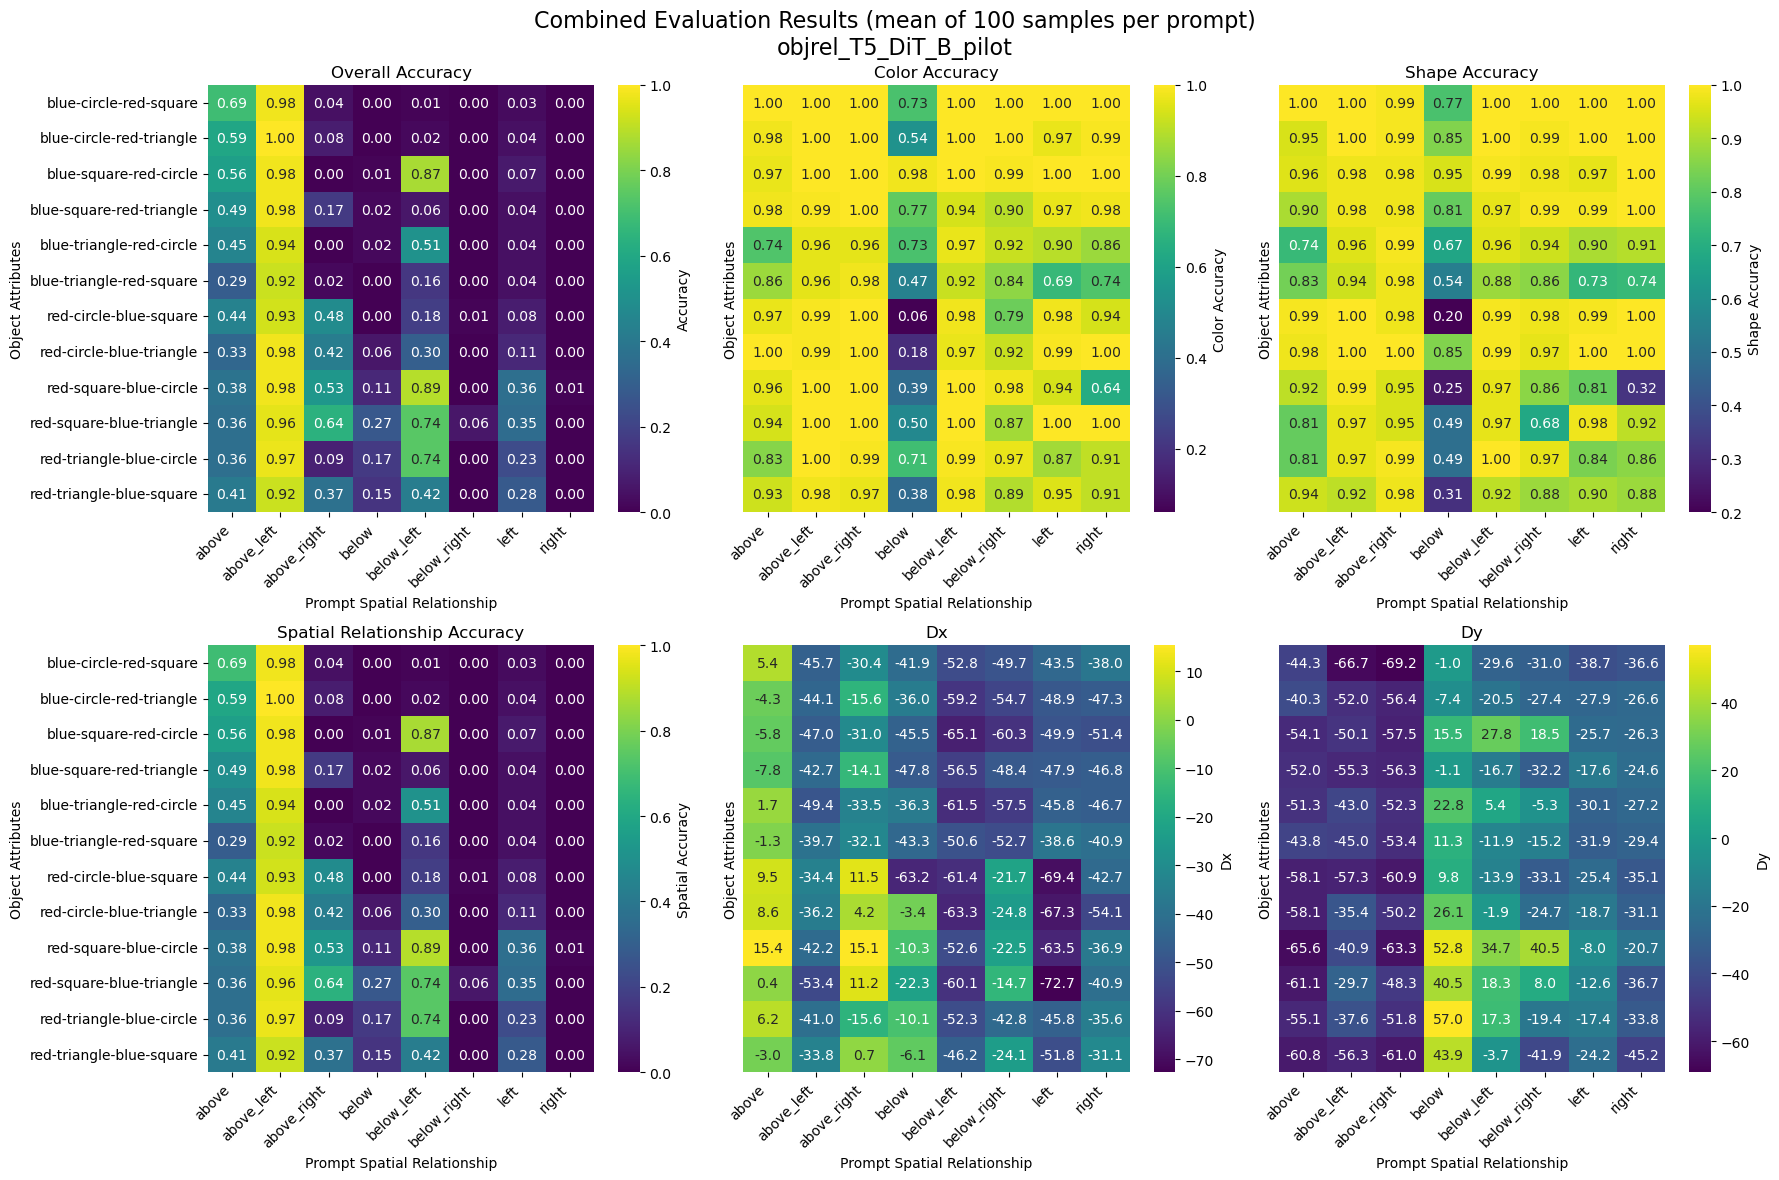

In [105]:
# Create a combined figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Accuracy by Prompt Spatial Relationship
pivot_df = prompt_eval_syn_df.pivot_table(
    index=['color1', 'shape1', 'color2', 'shape2'], 
    columns='relation_str', 
    values='overall_acc',
    aggfunc='mean'
)
sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.2f', cbar_kws={'label': 'Accuracy'}, ax=axes[0, 0])
axes[0, 0].set_title(f'Overall Accuracy')
axes[0, 0].set_xlabel('Prompt Spatial Relationship')
axes[0, 0].set_ylabel('Object Attributes')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), ha='right')

# Plot 2: Color Accuracy by Prompt Spatial Relationship
pivot_df = prompt_eval_syn_df.pivot_table(
    index=['color1', 'shape1', 'color2', 'shape2'], 
    columns='relation_str', 
    values='color_acc',
    aggfunc='mean'
)
sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.2f', cbar_kws={'label': 'Color Accuracy'}, ax=axes[0, 1])
axes[0, 1].set_title(f'Color Accuracy')
axes[0, 1].set_xlabel('Prompt Spatial Relationship')
axes[0, 1].set_ylabel('Object Attributes')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), ha='right')
# Get rid of the y ticks
axes[0, 1].set_yticks([])

# Plot 3: Shape Accuracy by Prompt Spatial Relationship
pivot_df = prompt_eval_syn_df.pivot_table(
    index=['color1', 'shape1', 'color2', 'shape2'], 
    columns='relation_str', 
    values='shape_acc',
    aggfunc='mean'
)
sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.2f', cbar_kws={'label': 'Shape Accuracy'}, ax=axes[0, 2])
axes[0, 2].set_title(f'Shape Accuracy')
axes[0, 2].set_xlabel('Prompt Spatial Relationship')
axes[0, 2].set_ylabel('Object Attributes')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].set_xticklabels(axes[0, 2].get_xticklabels(), ha='right')
# Get rid of the y ticks
axes[0, 2].set_yticks([])

# Plot 4: Spatial Relationship Accuracy
pivot_df = prompt_eval_syn_df.pivot_table(
    index=['color1', 'shape1', 'color2', 'shape2'], 
    columns='relation_str', 
    values='spatial_relationship_acc',
    aggfunc='mean'
)
sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.2f', cbar_kws={'label': 'Spatial Accuracy'}, ax=axes[1, 0])
axes[1, 0].set_title(f'Spatial Relationship Accuracy')
axes[1, 0].set_xlabel('Prompt Spatial Relationship')
axes[1, 0].set_ylabel('Object Attributes')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), ha='right')

# Plot 5: Dx by Object Attributes
pivot_df = prompt_eval_syn_df.pivot_table(
    index=['color1', 'shape1', 'color2', 'shape2'], 
    columns='relation_str', 
    values='Dx',
    aggfunc='mean'
)
sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.1f', cbar_kws={'label': 'Dx'}, ax=axes[1, 1])
axes[1, 1].set_title(f'Dx')
axes[1, 1].set_xlabel('Prompt Spatial Relationship')
axes[1, 1].set_ylabel('Object Attributes')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), ha='right')
# Get rid of the y ticks
axes[1, 1].set_yticks([])


# Plot 6: Dy by Object Attributes
pivot_df = prompt_eval_syn_df.pivot_table(
    index=['color1', 'shape1', 'color2', 'shape2'], 
    columns='relation_str', 
    values='Dy',
    aggfunc='mean'
)
sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.1f', cbar_kws={'label': 'Dy'}, ax=axes[1, 2])
axes[1, 2].set_title(f'Dy')
axes[1, 2].set_xlabel('Prompt Spatial Relationship')
axes[1, 2].set_ylabel('Object Attributes')
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].set_xticklabels(axes[1, 2].get_xticklabels(), ha='right')
# Get rid of the y ticks
axes[1, 2].set_yticks([])

plt.suptitle(f'Combined Evaluation Results (mean of 100 samples per prompt)\n{model_run_name}', fontsize=16, y=0.98)
plt.tight_layout()
saveallforms(eval_dir, f"relation_eval_heatmap_all_synopsis_{model_run_name}")
plt.show()

In [ ]:
acc_overall = eval_df["overall"].mean()
acc_shape = eval_df["shape"].mean()
acc_color = eval_df["color"].mean()
acc_spatial_relationship = eval_df["spatial_relationship"].mean()
Dx_mean = eval_df["Dx"].mean(skipna=True)
Dy_mean = eval_df["Dy"].mean(skipna=True)
Dx_std = eval_df["Dx"].std(skipna=True)
Dy_std = eval_df["Dy"].std(skipna=True)
N_valid = eval_df["Dx"].count()
N_total = len(eval_df)
print(f"accuracy color {acc_color:.2f}, shape {acc_shape:.2f}, spatial_relationship {acc_spatial_relationship:.2f}, overall {acc_overall:.2f}")
print(f"Dx {Dx_mean:.2f} ± {Dx_std:.2f}, Dy {Dy_mean:.2f} ± {Dy_std:.2f} (valid N={N_valid}/{N_total})")

accuracy color 0.96, shape 0.83, spatial_relationship 0.36, overall 0.36
Dx -0.75 ± 15.18, Dy -60.37 ± 17.16 (valid N=67/81)


In [ ]:
step_num = 160000
prompt_id = 1
prompt = "blue square below and to the right of a red circle"
scene_info = {'color1': 'blue',
  'shape1': 'Square',
  'color2': 'red',
  'shape2': 'Circle',
  'spatial_relationship': 'lower_right'}
out = pipeline(prompt, num_inference_steps=14, guidance_scale=4.5,
         num_images_per_prompt=81, generator=th.Generator(device="cuda").manual_seed(42), prompt_dtype=torch.float16)
# subimages = load_image_grid(step_num, prompt_id, sample_root=sample_root)


### Whole network at bfloat16

In [ ]:
del pipeline.text_encoder
del text_encoder
torch.cuda.empty_cache()
#%%

In [8]:
text_feat_dir_old = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot_rndemb/caption_feature_wmask'
T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
tokenizer = T5Tokenizer.from_pretrained(T5_path, )#subfolder="tokenizer")
if text_encoder_type == "T5":
    text_encoder = T5EncoderModel.from_pretrained(T5_path, load_in_8bit=False, torch_dtype=torch.bfloat16, )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
figdir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}/cross_attn_vis_figs"
os.makedirs(figdir, exist_ok=True)

config = read_config(join(savedir, 'config.py'))
weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length}
# train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()
num_layers = len(model.blocks)
transformer = Transformer2DModel(
        sample_size=image_size // 8,
        num_layers=len(model.blocks),
        attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
        in_channels=model.in_channels,
        out_channels=model.out_channels,
        patch_size=model.patch_size,
        attention_bias=True,
        num_attention_heads=model.num_heads,
        cross_attention_dim=model.blocks[0].hidden_size,
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=4096,
)
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict_convert(model.state_dict()))
pipeline = PixArtAlphaPipeline_custom.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=tokenizer,
    text_encoder=None,
    torch_dtype=weight_dtype,
)
ckptdir = join(savedir, "checkpoints")
ckpt = torch.load(join(ckptdir, ckpt_name))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
# pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
pipeline.tokenizer = tokenizer
pipeline.text_encoder = text_encoder
# pipeline.to(device="cuda", dtype=weight_dtype);
pipeline.to(device="cuda", dtype=torch.bfloat16);
# add attention map store hooks
# pipeline.transformer = replace_attn_processor(pipeline.transformer)
# attnvis_store = PixArtAttentionVisualizer_Store(pipeline)
# attnvis_store.setup_hooks()
# torch.cuda.empty_cache()

2025-07-19 00:39:30,602 - PixArt - WARNING - lewei scale: (1.0,), base size: 8


Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.
/tmp/ipykernel_1534014/2804847181.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have ful

pipeline.text_encoder.dtype torch.bfloat16
pipeline.transformer.dtype torch.bfloat16
torch.Size([98, 120, 4096])
torch.Size([98, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

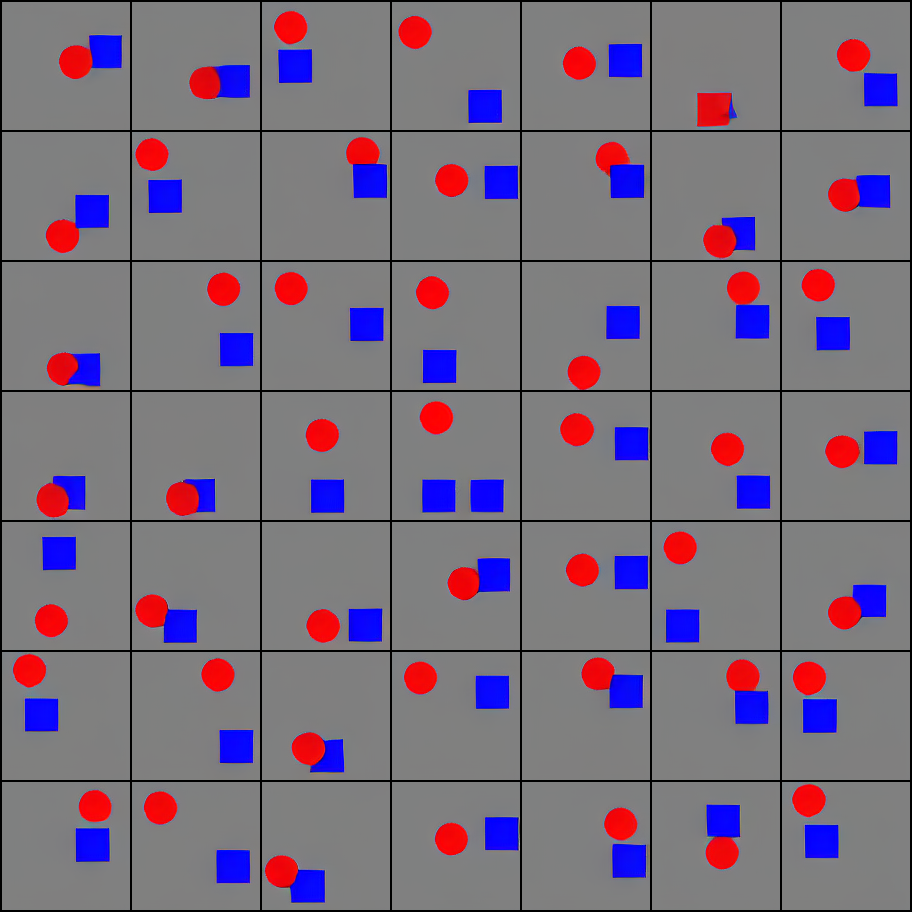

In [11]:
print("pipeline.text_encoder.dtype", pipeline.text_encoder.dtype)
print("pipeline.transformer.dtype", pipeline.transformer.dtype)
out = pipeline("a blue square below and to the right of a red circle", num_inference_steps=14, guidance_scale=4.5,
         num_images_per_prompt=49, generator=th.Generator(device="cuda").manual_seed(42), prompt_dtype=None)
pil_images_to_grid(out.images)

### Both transformer and T5 Float16

In [16]:
del pipeline.text_encoder
del text_encoder
torch.cuda.empty_cache()
#%%

In [17]:
text_feat_dir_old = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot_rndemb/caption_feature_wmask'
T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
tokenizer = T5Tokenizer.from_pretrained(T5_path, )#subfolder="tokenizer")
if text_encoder_type == "T5":
    text_encoder = T5EncoderModel.from_pretrained(T5_path, load_in_8bit=False, torch_dtype=torch.float16, )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
figdir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}/cross_attn_vis_figs"
os.makedirs(figdir, exist_ok=True)

config = read_config(join(savedir, 'config.py'))
weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length}
# train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()
num_layers = len(model.blocks)
transformer = Transformer2DModel(
        sample_size=image_size // 8,
        num_layers=len(model.blocks),
        attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
        in_channels=model.in_channels,
        out_channels=model.out_channels,
        patch_size=model.patch_size,
        attention_bias=True,
        num_attention_heads=model.num_heads,
        cross_attention_dim=model.blocks[0].hidden_size,
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=4096,
)
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict_convert(model.state_dict()))
pipeline = PixArtAlphaPipeline_custom.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=tokenizer,
    text_encoder=None,
    torch_dtype=weight_dtype,
)
ckptdir = join(savedir, "checkpoints")
ckpt = torch.load(join(ckptdir, ckpt_name))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
# pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
pipeline.tokenizer = tokenizer
pipeline.text_encoder = text_encoder.to(device="cuda", )
pipeline.to(device="cuda", dtype=weight_dtype);
# pipeline.to(device="cuda", dtype=torch.bfloat16);
# add attention map store hooks
# pipeline.transformer = replace_attn_processor(pipeline.transformer)
# attnvis_store = PixArtAttentionVisualizer_Store(pipeline)
# attnvis_store.setup_hooks()
# torch.cuda.empty_cache()

2025-07-19 00:44:29,503 - PixArt - WARNING - lewei scale: (1.0,), base size: 8


Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.
/tmp/ipykernel_1534014/3194016346.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have ful

pipeline.text_encoder.dtype torch.float16
pipeline.transformer.dtype torch.float16
torch.Size([98, 120, 4096])
torch.Size([98, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

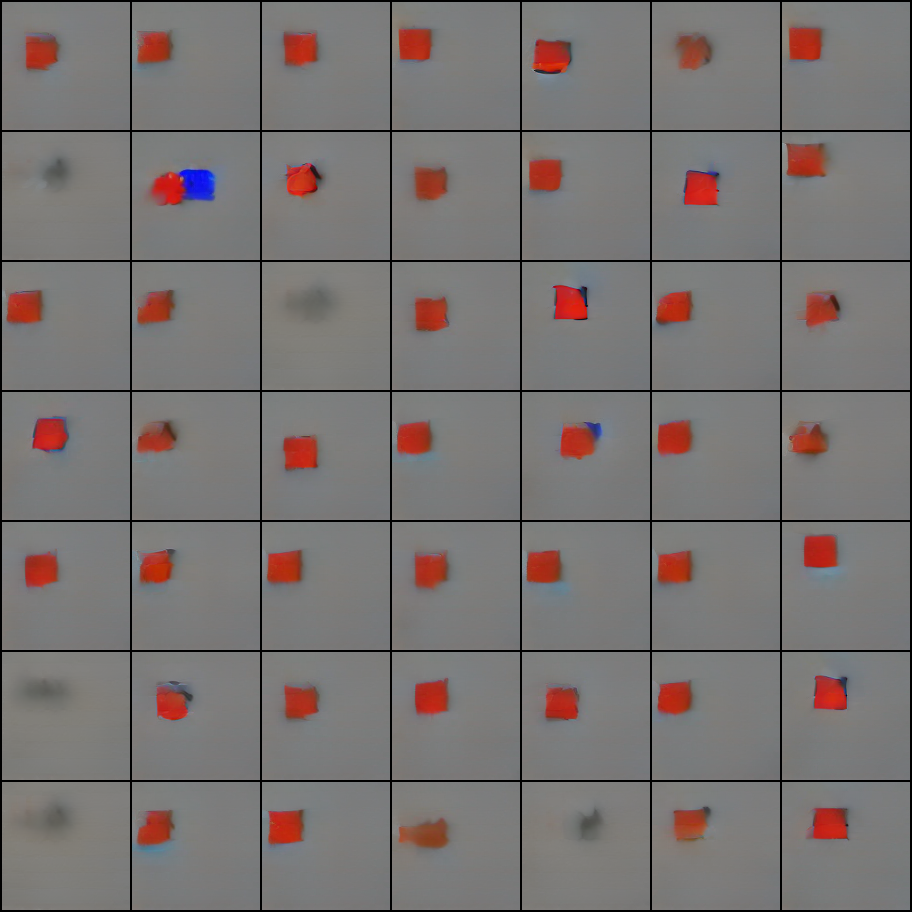

In [19]:
print("pipeline.text_encoder.dtype", pipeline.text_encoder.dtype)
print("pipeline.transformer.dtype", pipeline.transformer.dtype)
out = pipeline("a blue square below and to the right of a red circle", num_inference_steps=14, guidance_scale=4.5,
         num_images_per_prompt=49, generator=th.Generator(device="cuda").manual_seed(42), prompt_dtype=torch.float16)
pil_images_to_grid(out.images)

### float16 T5 embedding, bfloat16 DiT weights

In [20]:
del pipeline.text_encoder
del text_encoder
torch.cuda.empty_cache()

In [21]:
text_feat_dir_old = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot_rndemb/caption_feature_wmask'
T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
tokenizer = T5Tokenizer.from_pretrained(T5_path, )#subfolder="tokenizer")
if text_encoder_type == "T5":
    text_encoder = T5EncoderModel.from_pretrained(T5_path, load_in_8bit=False, torch_dtype=torch.float16, )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [22]:
savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
figdir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}/cross_attn_vis_figs"
os.makedirs(figdir, exist_ok=True)

config = read_config(join(savedir, 'config.py'))
# weight_dtype = torch.float32
# if config.mixed_precision == "fp16": # accelerator.
#     weight_dtype = torch.float16
# elif config.mixed_precision == "bf16": # accelerator.
#     weight_dtype = torch.bfloat16

weight_dtype = torch.bfloat16

image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length}
# train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()
num_layers = len(model.blocks)
transformer = Transformer2DModel(
        sample_size=image_size // 8,
        num_layers=len(model.blocks),
        attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
        in_channels=model.in_channels,
        out_channels=model.out_channels,
        patch_size=model.patch_size,
        attention_bias=True,
        num_attention_heads=model.num_heads,
        cross_attention_dim=model.blocks[0].hidden_size,
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=4096,
)
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict_convert(model.state_dict()))
pipeline = PixArtAlphaPipeline_custom.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=tokenizer,
    text_encoder=None,
    torch_dtype=weight_dtype,
)
ckptdir = join(savedir, "checkpoints")
ckpt = torch.load(join(ckptdir, ckpt_name))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
# pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
pipeline.tokenizer = tokenizer
pipeline.to(device="cuda", dtype=weight_dtype);
pipeline.text_encoder = text_encoder.to(device="cuda", )
# pipeline.to(device="cuda", dtype=torch.bfloat16);

2025-07-19 00:45:24,547 - PixArt - WARNING - lewei scale: (1.0,), base size: 8


Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.
/tmp/ipykernel_1534014/3599758373.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have ful

pipeline.text_encoder.dtype torch.float16
pipeline.transformer.dtype torch.bfloat16
torch.Size([98, 120, 4096])
torch.Size([98, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

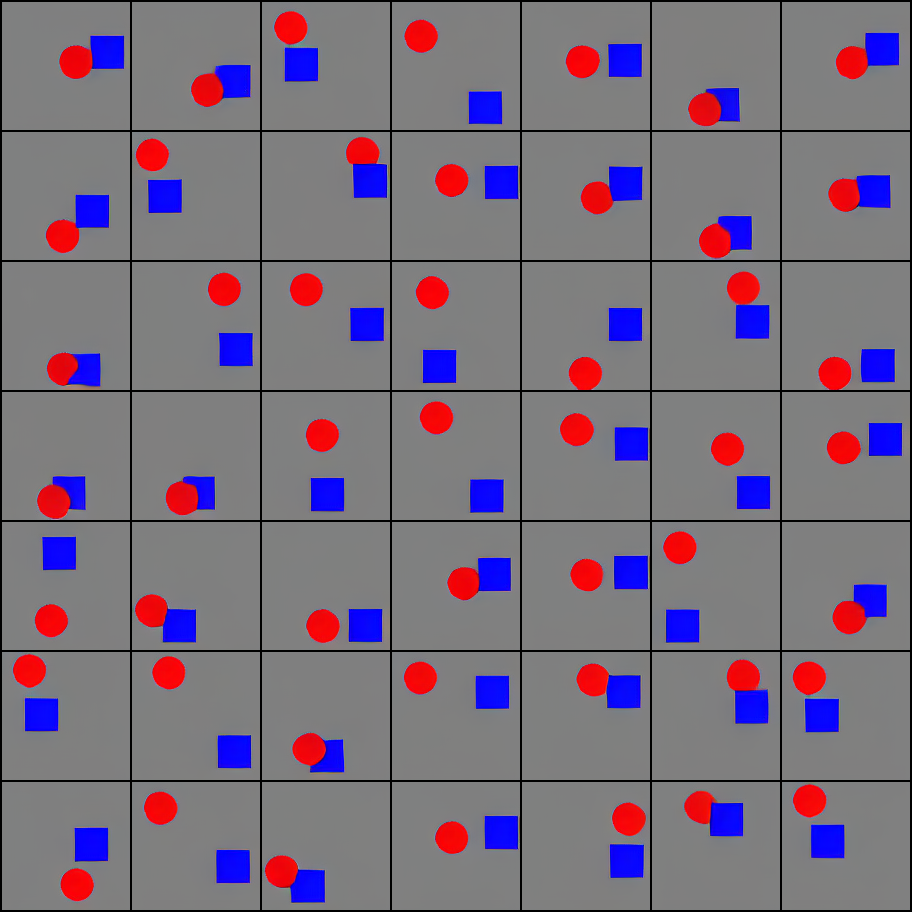

In [23]:
print("pipeline.text_encoder.dtype", pipeline.text_encoder.dtype)
print("pipeline.transformer.dtype", pipeline.transformer.dtype)
out = pipeline("a blue square below and to the right of a red circle", num_inference_steps=14, guidance_scale=4.5,
         num_images_per_prompt=49, generator=th.Generator(device="cuda").manual_seed(42), prompt_dtype=torch.bfloat16)
pil_images_to_grid(out.images)